# 자동차 가격 예측 (추가)
- 앞서 진행했던 자동차 가격 예측 프로젝트에 더해 딥러닝/스태킹 앙상블 등 추가적인 모델 적용을 통해 성능 향상을 도모한다

- 데이터와 앞서 사용했던 함수들을 불러온다

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
car_df_org = pd.read_csv("C:/Users/pbyim/OneDrive/바탕 화면/시온/Data/car_price_prediction.csv")
car_df = car_df_org.copy()
car_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [18]:
def get_outlier_idx(df, column, weight=1.5):
    
    quantile25 = np.percentile(df[column].values, 25)
    quantile75 = np.percentile(df[column].values, 75)

    iqr = weight * (quantile75-quantile25)
    lower_bound = quantile25-iqr
    upper_bound = quantile75+iqr

    outlier_idx = df[(df[column]<lower_bound) | (df[column]>upper_bound)].index
    return outlier_idx

In [10]:
def process_car_data(car_df_org):
    car_df = car_df_org.copy()
    car_df = car_df.drop_duplicates()
    car_df = car_df.drop('ID', axis = 1)
    car_df['Levy'].replace('-', 0, inplace=True)
    car_df['Levy'] = car_df['Levy'].apply(lambda x: int(x))
    car_df['Price'] = np.log1p(car_df['Price'])
    car_df['Mileage'] = car_df['Mileage'].str[:-3].apply(lambda x: int(x))
    car_df['Mileage'] = np.log1p(car_df['Mileage'])

    outlier_indices = get_outlier_idx(car_df, 'Price')
    car_df = car_df.drop(outlier_indices, axis=0)
    
    return car_df

In [12]:
def get_rmse(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(model.__class__.__name__, 'RMSE:', np.round(rmse,4))
    return np.round(rmse,4)

def get_model_rmses(models, X_test, y_test):
    rmses = []
    for model in models:
        rmse = get_rmse(model, X_test, y_test)
        rmses.append(rmse)
    return rmses

In [14]:
 def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index = X.columns)
    coef_top = coef.sort_values(ascending=False).head(n)
    coef_bottom = coef.sort_values(ascending=False).tail(n)
    return coef_top, coef_bottom

def visualize_coef(models, n=10):
    fig, axes = plt.subplots(figsize=(24,10), nrows=1, ncols=len(models))
    for i, model in enumerate(models):
        coef_top, coef_bottom = get_top_bottom_coef(model, n)
        coef = pd.concat([coef_top, coef_bottom])
        
        axes[i].set_title('Model:'+ model.__class__.__name__)
        axes[i].tick_params(axis='y', direction='in', pad=-120)
        sns.barplot(x=coef.values, y=coef.index, ax=axes[i])

In [272]:
def visualize_ftr_importances(models):
    fig, axes = plt.subplots(figsize=(10,6), ncols=len(models))
    for i, model in enumerate(models):
        ftr_imp = pd.Series(data=model.feature_importances_, index=X_train.columns)
        ftr_imp_top20 = ftr_imp.sort_values(ascending=False)[:20]
        
        axes[i].set_title(model.__class__.__name__)
        axes[i].tick_params(axis='y', pad=-120)
        sns.barplot(x=ftr_imp_top20.values, y=ftr_imp_top20.index, ax=axes[i])
    plt.tight_layout()
    plt.show()

In [16]:
def get_best_params(model, param_grid):
    grid_model = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = -1*grid_model.best_score_
    print(f'Model: {model.__class__.__name__}')
    print(f'RMSE: {rmse} Best parameter: {grid_model.best_params_} \n')
    best_param = grid_model.best_params_
    return best_param

In [21]:
def process_duplicates(X, duplicated_col):
    cols = X.columns.tolist()
    dup_idx = [i for i, col in enumerate(cols) if col == duplicated_col]
    
    if len(dup_idx) > 1:
        for count, idx in enumerate(dup_idx[1:], start=2):
            cols[idx] = f"{duplicated_col}_{count}"
    
    X.columns = cols
    return X

### 딥러닝 모델 및 스태킹 앙상블 모델 적용

- 데이터 준비

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [72]:
car_df = process_car_data(car_df_org)
car_df_encoded = pd.get_dummies(car_df, drop_first=True)
print(car_df.shape, car_df_encoded.shape)
car_df.head(3)

(16907, 17) (16907, 1767)


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,9.497697,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,12.133534,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,9.718482,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,12.165256,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,9.044050,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,12.206078,4.0,Variator,Front,04-May,Right-hand drive,Black,2


In [74]:
X = car_df_encoded.drop('Price', axis=1)
y = car_df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Pytorch 딥러닝 모델 구축

In [77]:
from skorch import NeuralNetRegressor
import torch
import torch.nn as nn

In [79]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, X):
        return self.net(X)
    
input_dim = X_train.shape[1]

mlp_reg = NeuralNetRegressor(ㅌ
    module=MLP,
    module__input_dim=input_dim,
    module__hidden_dim=64,
    max_epochs=50,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0 
)

In [87]:
mlp_reg.fit(X_train.values.astype('float32'), y_train.values.astype('float32').reshape(-1, 1))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP(
    (net): Sequential(
      (0): Linear(in_features=1766, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  ),
)

In [93]:
get_rmse(
    model=mlp_reg, 
    X_test=X_test.values.astype(np.float32), 
    y_test=y_test.values.astype(np.float32).reshape(-1, 1)
)

NeuralNetRegressor RMSE: 1.0009


1.0009

- 아직 선형 모델에 비해 성능이 뛰어나진 않은 모습, 하이퍼 파라미터 튜닝 수행

In [100]:
from sklearn.model_selection import GridSearchCV
# 하이퍼파라미터 후보 설정
param_grid = {
    'lr': [0.001, 0.0005],
    'max_epochs': [50, 100],
    'module__hidden_dim': [64, 128]
}

# GridSearchCV를 통해 하이퍼파라미터 튜닝
# scoring은 회귀 모델이므로 neg_mean_squared_error 사용 (낮을수록 좋음)
gs = GridSearchCV(
    estimator=mlp_reg,      # 이전에 정의한 NeuralNetRegressor 객체
    param_grid=param_grid,
    cv=3,                   # 3-Fold 교차검증
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# 데이터는 numpy array로 변환 (타깃은 (n,1) 형태로 맞춤)
gs.fit(X_train.values.astype(np.float32), y_train.values.astype(np.float32).reshape(-1, 1))

# 최적 하이퍼파라미터와 교차검증 점수 출력
print("Best Parameters:", gs.best_params_)
print("Best CV Score (neg MSE):", gs.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'lr': 0.001, 'max_epochs': 100, 'module__hidden_dim': 64}
Best CV Score (neg MSE): -0.7647098104159037


In [102]:
mlp_reg = NeuralNetRegressor(
    module=MLP,
    module__input_dim=input_dim,
    module__hidden_dim=64,
    max_epochs=100,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0 
)

mlp_reg.fit(X_train.values.astype('float32'), y_train.values.astype('float32').reshape(-1, 1))
get_rmse(
    model=mlp_reg, 
    X_test=X_test.values.astype(np.float32), 
    y_test=y_test.values.astype(np.float32).reshape(-1, 1)
)

NeuralNetRegressor RMSE: 0.8317


0.8317

- 모델 성능 상승 (1.0009 -> 0.8317)
- 하지만 선형 모델에 비해서 조차 성능이 낮고 수행시간이 오래 걸림
- 더욱 고도화된 모델을 구축하면 성능이 더 좋아질 수 있겠지만 우선 다음 단계로 이동

### 스태킹 앙상블 모델 구축

In [214]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
import re

In [173]:
X.columns = X.columns.map(lambda x: re.sub('[^a-zA-Z0-9_]','_', str(x)))
X = process_duplicates(X, "Model_CT_200h_F_sport")
X = process_duplicates(X, "Model_Prius________")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [177]:
ridge_reg = Ridge()
lasso_reg = Lasso()

ridge_params={'alpha': np.logspace(-4, 4, 50)}
lasso_params={'alpha': np.logspace(-4, 4, 50)}

ridge_alpha = get_best_params(ridge_reg, ridge_params)
lasso_alpha = get_best_params(lasso_reg, lasso_params)

Model: Ridge
RMSE: 0.7607989158011635 Best parameter: {'alpha': 2.559547922699533} 

Model: Lasso
RMSE: 0.7623340157698397 Best parameter: {'alpha': 0.0001} 



In [178]:
ridge_reg = Ridge(alpha=ridge_alpha['alpha'])
lasso_reg = Lasso(alpha=lasso_alpha['alpha'])

In [181]:
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

In [183]:
xgb_search_space = {
    'max_depth':hp.quniform('max_depth', 10, 20, 1),
    'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 0.8),
    'subsample':hp.uniform('subsample', 0.5, 0.8)
}

def xgb_obj_func(search_space):
    xgb_reg = XGBRegressor(n_estimators=200,
                           max_depth=int(search_space['max_depth']), 
                           learning_rate=search_space['learning_rate'], 
                           colsample_bytree=search_space['colsample_bytree'], 
                           subsample=search_space['subsample'])
    
    rmse = -1*cross_val_score(xgb_reg, X, y, scoring='neg_root_mean_squared_error', cv=5)
    
    return {'loss':np.mean(rmse), 'status': STATUS_OK}

In [193]:
trial_vals = Trials()

xgb_best = fmin(fn=xgb_obj_func, space=xgb_search_space, algo=tpe.suggest, max_evals=50, trials=trial_vals)
print(f'Best: {xgb_best}')

100%|██████████████████████████████████████████████| 50/50 [1:15:22<00:00, 90.44s/trial, best loss: 0.4419482711513492]
Best: {'colsample_bytree': 0.7375950074756181, 'learning_rate': 0.046378639681760966, 'max_depth': 19.0, 'subsample': 0.7680060495062957}


In [195]:
lgbm_search_space = {'max_depth':hp.quniform('max_depth',25,40,1),
                     'num_leaves':hp.quniform('num_leaves',100,200,1),
                     'subsample':hp.uniform('subsample',0.4,0.8),
                     'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.1))}

def lgbm_obj_func(search_space):
    lgbm_reg = LGBMRegressor(n_estimators=200,
                           max_depth=int(search_space['max_depth']), 
                           learning_rate=search_space['learning_rate'], 
                           num_leaves=int(search_space['num_leaves']), 
                           subsample=search_space['subsample'],
                           verbosity=-1)
    
    rmse = -1*cross_val_score(lgbm_reg, X, y, scoring='neg_root_mean_squared_error', cv=5)
    
    return {'loss':np.mean(rmse), 'status': STATUS_OK}

In [197]:
trial_vals = Trials()

lgbm_best = fmin(fn=lgbm_obj_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=50, trials=trial_vals)
print(f'Best: {lgbm_best}')

100%|████████████████████████████████████████████████| 50/50 [04:30<00:00,  5.41s/trial, best loss: 0.4638466093104287]
Best: {'learning_rate': 0.09941659090183731, 'max_depth': 27.0, 'num_leaves': 103.0, 'subsample': 0.5438694707814596}


In [199]:
rf_reg = RandomForestRegressor(n_estimators = 200)

xgb_reg = XGBRegressor(n_estimators = 200, 
                       max_depth=int(xgb_best['max_depth']), 
                       learning_rate=xgb_best['learning_rate'],
                       colsample_bytree=xgb_best['colsample_bytree'], )

lgbm_reg=LGBMRegressor(n_estimators=200, 
                    num_leaves=int(lgbm_best['num_leaves']),
                    max_depth=int(lgbm_best['max_depth']),
                    subsample=lgbm_best['subsample'],
                    learning_rate=lgbm_best['learning_rate'], verbosity=-1)

In [216]:
estimators = [
    ('ridge', ridge_reg),
    ('lasso', lasso_reg),
    ('random_forest', rf_reg),
    ('xgboost', xgb_reg),
    ('lgbm', lgbm_reg)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),  # 간단한 선형 회귀로 최종 앙상블
    cv=5,
    n_jobs=-1
)

In [207]:
# 개별 모델 학습/평가
all_models = [ridge_reg, lasso_reg, rf_reg, xgb_reg, lgbm_reg]

for model in all_models:
    model.fit(X_train, y_train)

get_model_rmses(all_models, X_test, y_test)

Ridge RMSE: 0.7688
Lasso RMSE: 0.7713
RandomForestRegressor RMSE: 0.4589
XGBRegressor RMSE: 0.4462
LGBMRegressor RMSE: 0.4581


[0.7688, 0.7713, 0.4589, 0.4462, 0.4581]

In [218]:
# 스태킹 모델 학습/평가
stacking_model.fit(X_train, y_train)
get_rmse(stacking_model, X_test, y_test)

StackingRegressor RMSE: 0.4407


0.4407

- 현재까지 가장 성능이 좋음

In [224]:
# 각 모델 기여도 확인
final_lr = stacking_model.final_estimator_
print(final_lr.coef_)  # 각 베이스 모델 예측에 대한 계수

[-0.07771937  0.13441884  0.15321373  0.65205905  0.17481841]


In [226]:
# ridge를 제외한 버전 시도
estimators = [
    ('lasso', lasso_reg),
    ('random_forest', rf_reg),
    ('xgboost', xgb_reg),
    ('lgbm', lgbm_reg)
]

stacking_wo_ridge = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),  # 간단한 선형 회귀로 최종 앙상블
    cv=5,
    n_jobs=-1
)

stacking_wo_ridge.fit(X_train, y_train)
get_rmse(stacking_wo_ridge, X_test, y_test)

final_lr = stacking_wo_ridge.final_estimator_
print(final_lr.coef_)  # 각 베이스 모델 예측에 대한 계수

StackingRegressor RMSE: 0.4404
[0.05779464 0.14345927 0.65941126 0.1766649 ]


- Ridge를 제외한 버전이 아주 미세하게 성능이 더 좋음, 이를 최종 모델로 결정
- 앞선 프로젝트에서는 선형 모델의 회귀 계수, 트리 베이스 모델의 feature_importaces로 변수의 영향을 파악했다
- 이번에는 SHAP와 스태킹 모델을 이용해 변수를 해석해보겠다

In [236]:
import shap

PermutationExplainer explainer: 3383it [1:21:31,  1.45s/it]                                                            


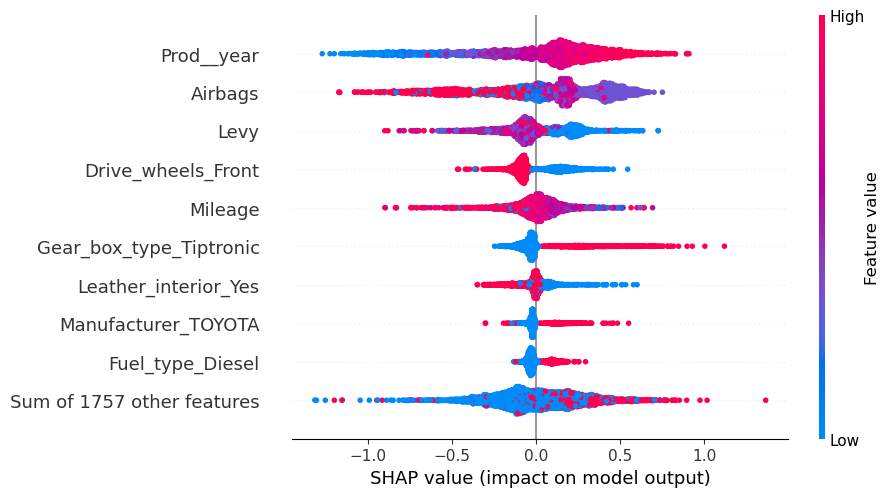

In [250]:
# 1) 샘플링 + 변환
X_bg = X_train.sample(2000, random_state=42)
X_bg = X_bg.astype('float32')  # 전부 float 변환

explainer = shap.Explainer(
    stacking_wo_ridge.predict, 
    X_bg,
    algorithm="permutation"
)

# 2) 테스트도 float 변환
X_test_float = X_test.astype('float32')
shap_values = explainer(X_test_float)
shap.plots.beeswarm(shap_values)

### SHAP beeswarm 플롯 해석

#### 1. SHAP 플롯 해석

본 플롯에서 **가로축**은 **SHAP value**(해당 피처가 예측값을 얼마나 올리거나 내리는가),  
**색상**은 “해당 피처의 원본 값이 낮은지(파랑) / 높은지(빨강)”,  
**세로축**은 피처 이름(위쪽일수록 중요도↑).

각 피처에 대해, 
- **점이 오른쪽(+)**으로 치우치면 “이 피처가 그 샘플의 예측값을 높이는 방향”  
- **왼쪽(-)**이면 “예측값을 낮추는 방향”  
- **빨강**: 피처 값이 높음, **파랑**: 피처 값이 낮음.

1. **Prod__year (맨 위, 영향력 최대)**

- **연식이 높은 차(빨강)**일수록 대체로 **오른쪽(+)** SHAP value → **최근 연식**이 가격을 올린다  
- **연식이 낮은 차(파랑)**는 왼쪽(음수) → 오래된 차일수록 가격이 떨어지는 효과  
- 이 피처가 전체 예측에 가장 크게 기여

2. **Airbags (2번째)**

- 에어백 수가 많은(빨강) 샘플도 왼쪽(음수)~오른쪽(양수) 분포가 **제법 넓게** 펼쳐져 혼재  
- 대체로 샘플군이 0 근처나 양수 방향에 많이 분포하긴 하나, 특정 상황(상관된 변수)에서 음수로 작용하는 샘플도 존재  
- 대체로 “에어백 많음”이 가격 상승 요인인 경향이지만, 다른 변수가 더 지배적인 경우 음수 기여도 가능

3. **Levy**

- Levy가 높을수록(빨강) 대체로 +방향, 낮을수록(파랑) -방향 → 세금(Levy)이 크면 예측 가격도 오른다고 모델이 판단  
- 단, 중간값 일부는 보라/분홍색 분포가 0 근처에 몰릴 수 있어, 일부 예외 샘플 존재

4. **Drive_wheels_Front**

- 전륜구동 여부(이진)로 추정  
- 빨강(Front=1) vs 파랑(Front=0)이 비슷한 구간에 섞여 있으나, 약간 왼/오른쪽 편차가 있음  
- 전륜일 때 가격을 소폭 올리거나 내릴 수도 있고, 분포 폭이 그리 크지 않음(최대 ±0.3?)

5. **Mileage**

- 빨강(주행거리 많음)은 대체로 왼쪽(음수) → 주행거리가 많을수록 가격이 떨어지는 경향  
- 파랑(주행거리 적음)은 오른쪽(양수) 근처 분포  
- “적은 주행거리 → 가격 높임”이라는 직관과 부합

6. **Gear_box_type_Tiptronic**

- 빨강(=Tiptronic=1 추정)일 때 약간 +방향, 파랑(=0)은 약간 -방향으로 보임  
- 실제로 Tiptronic 변속기인 경우 가격이 조금 올라가는 경향이 있음

7. **Leather_interior_Yes**

- 가죽 시트(Yes=1, 빨강) → 양수, No=0(파랑) → 음수 경향  
- 가죽 interior가 가격을 올린다는 직관적 해석 가능

8. **Manufacturer_TOYOTA**

- “TOYOTA=1”인 경우(빨강)는 약간 양수 쪽, 아닌 경우(파랑)는 음수 분포  
- 즉, “토요타” 차종은 다른 브랜드 대비 약간 더 높은 가격을 예측

9. **Fuel_type_Diesel**

- 디젤이면(빨강) +0.1~0.2 정도, 가솔린/LPG(파랑)면 0 근처나 음수  
- 디젤 차가 조금 더 고가로 예측되는 경향

10. **Sum of 1757 other features**

- 나머지 많은 더미변수를 통합 표시. 대체로 음수 분포가 넓게 깔려 있음.  
- 세부적 해석은 어렵지만, 여러 희소 변수가 종합적으로 약간 가격을 낮추는 편인 샘플이 많다는 의미

---

#### 2. 비즈니스 인사이트 도출

1. **가격 결정의 주된 요인**  
   - **연식(Prod__year), 주행거리(Mileage), 에어백(Airbags), Levy** 등이 가장 큰 영향  
   - 즉, 중고차 시장에서 “연식이 최근, 주행거리 적고, 에어백이 많고, (Levy가 큰?)” 차량이 **고가** 책정된다.  
   - 이는 소비자 입장에서도 “안전사양이 풍부하고, 덜 달린 차, 최근년식일수록 비싸다”는 일반적 통념과 일치

2. **옵션/부가 특성**  
   - 가죽 시트(Leather_interior_Yes), Tiptronic 변속기, 디젤연료, 특정 제조사(TOYOTA) 여부가 추가로 “가격 상승” 요인이 될 수 있음  
   - 따라서 중고 거래 시, 옵션/브랜드별 프리미엄이 적용되는 것을 시사

3. **Drive_wheels_Front**  
   - 전륜 구동이 가격에 미치는 영향이 비교적 적거나, 상반된 샘플도 존재(분포 폭이 꽤 넓음).  
   - 이런 경우, 일부 차종(전륜 vs 4륜/후륜)에 따라 큰 차이가 없거나, 다른 변수(엔진, 차급)와 연관돼 해석해야 할 수도 있음.

4. **“Sum of 1757 other features”**  
   - 대부분의 “나머지 희소 더미”는 모델이 전반적으로 음수 보정을 하는 편인데,  
   - 이는 “특정 레어옵션이나 희소한 카테고리”가 평균적으로 가격에 부정 영향을 준다거나, 단순히 잡음으로 작용하고 있음을 암시.  
   - 해당 부분을 좀 더 세분화해보면, 혹시 특정 브랜드/색상/옵션이 실제로는 +인 것도 있을 수 있으니, 필요하면 별도 분석

---

#### 3. 추가 해석/확인 작업

1. **PDP or ICE**  
   - “에어백이 정말 많을수록 가격을 항상 높이는지” → Partial Dependence Plot로 실제 관계 시각화  
   - “Levy”가 높은 차가 왜 가격이 높은지? → 도메인 상항(어떤 종류의 세금인지)을 재확인  
2. **상호작용**  
   - Mileage가 높지만 연식이 매우 새 차인 경우 등, 복합적인 경우를 ICE로 확인할 수 있음.  
3. **로컬 해석**  
   - 특정 개별 샘플(“이 차는 왜 이렇게 가격 예측이 높/낮을까?”)에 대해 SHAP waterfall plot을 보면, 어떤 피처가 가장 크게 기여했는지 파악 가능.

---

#### 결론

**1. 요인별 영향**  
- **연식, 에어백, 세금(Levy), 주행거리** 등이 가격 형성의 핵심.  
- 그 외 옵션(가죽 시트, Tiptronic 변속기, 디젤), 제조사(TOYOTA)는 중간 정도의 추가 프리미엄 요인.

**2. 실제 데이터 검증**  
- 이 해석이 “정말 비즈니스 로직과 부합”하는지,  
- 특정 피처(에어백이 많으면 정말 비싼가? Levy가 높은 건 뭔가?)는 추가 분석으로 미스매치 없는지 확인 필요.

**3. 활용**  
- 중고차 매매가 산정, 판매 전략, 옵션별 프리미엄 설정, 브랜드별 가치 분석에 인사이트 제공.  
- “연식 높고, 주행거리 적고, 안전사양 많은 차”에 특히 프리미엄 붙이도록 가격 책정 방안 수립 가능.

### 선형모델 회귀계수 및 트리모델 feature importances 시각화 및 SHAP와의 비교

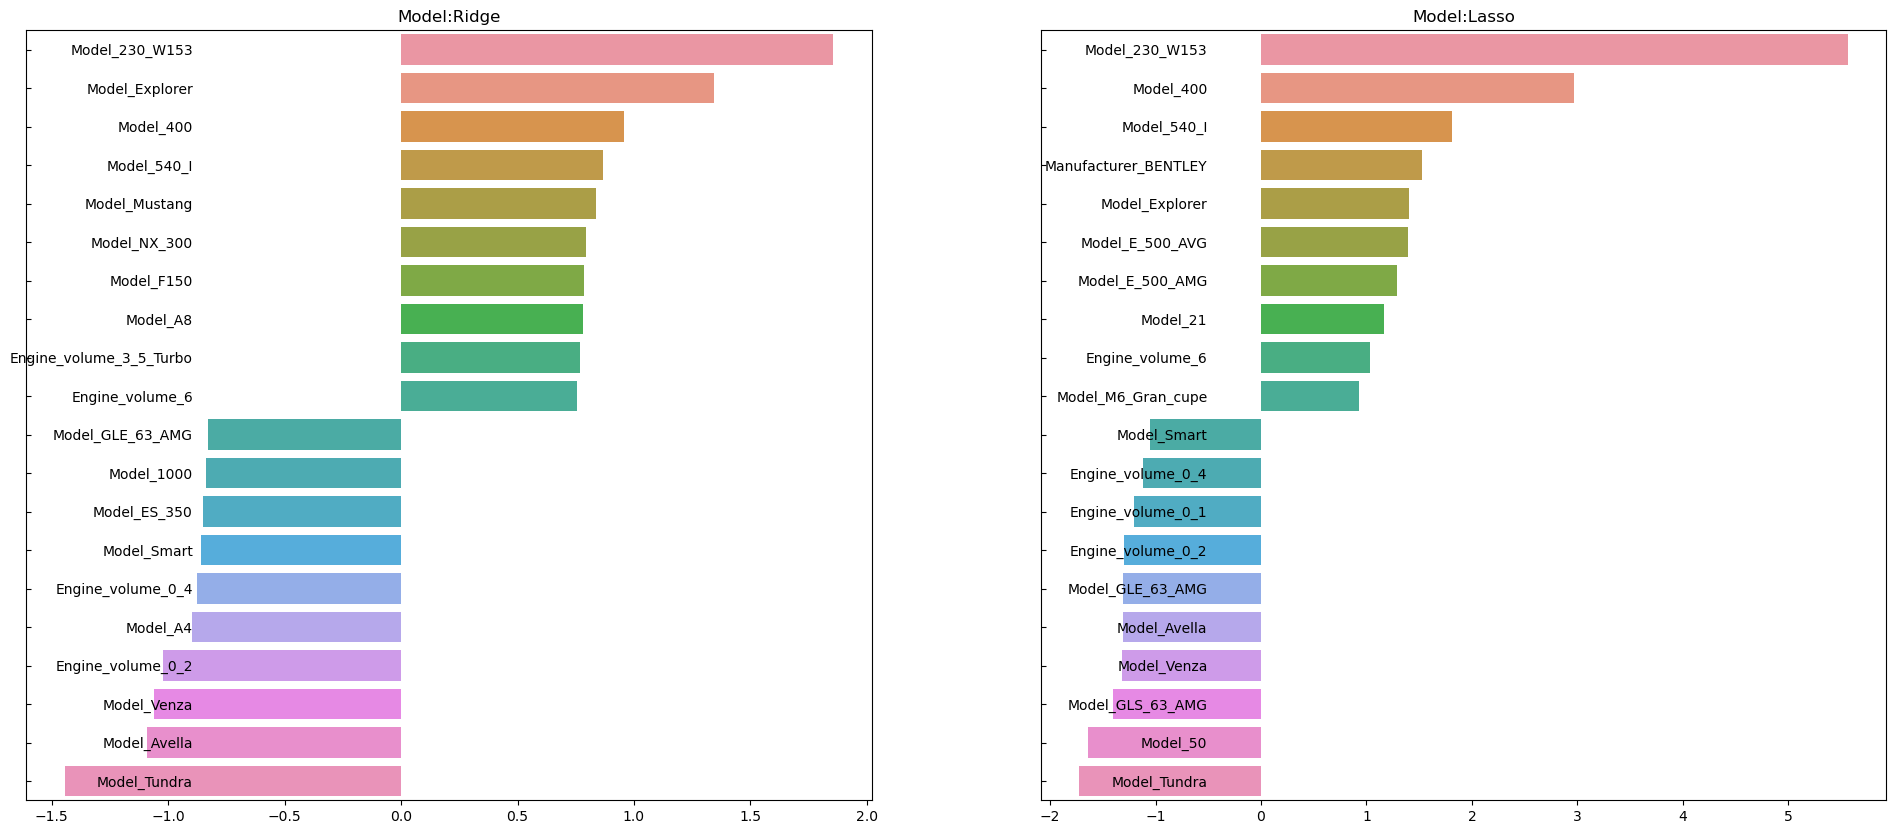

In [270]:
visualize_coef([ridge_reg,lasso_reg])

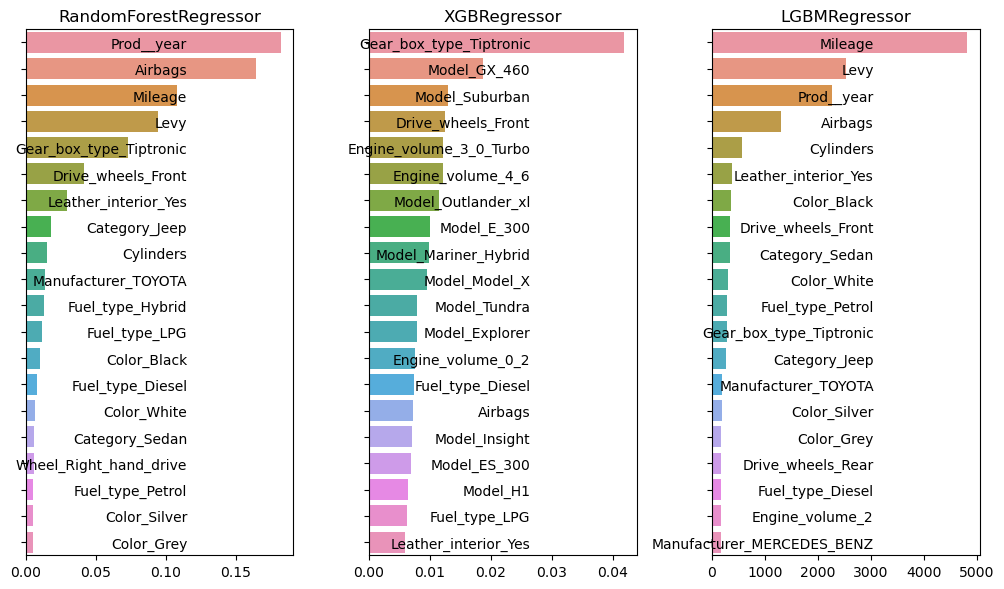

In [274]:
visualize_ftr_importances([rf_reg,xgb_reg,lgbm_reg])

#### 1. 선형 모델 결과 해석

1. **상위권(양수) 모델들**  
   - 예: `Model_230_W153`, `Model_400`, `Model_540_i`, `Model_Explorer` 등 특정 차종이 큰 **양의 계수**를 가짐  
   - 의미: 이들 차종(dummy 변수가 1이면) 중고차 가격을 **상승**시키는 방향으로 작용  
   - Lasso에서 계수가 더 극단적으로 클 수 있는데, 이는 L1 규제로 특정 변수에 가중을 크게 줄 수 있기 때문

2. **하위권(음수) 모델들**  
   - 예: `Model_Tundra`, `Model_Avella`, `Model_Venza` 등은 **음수 계수**  
   - 의미: 이들 차종이면 가격을 **낮추는** 쪽으로 작용  
   - 숫자가 -2.0 정도라면, 해당 차종이 1일 때 가격이 그만큼 깎인다고 해석

---

#### 2. 인사이트 도출

1. **차종(Model_***)이 가격에 큰 영향  
   - 예: 230_W153, 400, 540_i, Explorer 등은 고가, Tundra/Avella는 저가 쪽  
2. **Lasso vs Ridge 신뢰도**  
   - Lasso의 극단적 계수는 “이 차종이 정말 고가 그룹에 강하게 연결”일 수도 있지만, 공선성 탓에 과대추정 가능  
   - 실제 예측 성능과 도메인 검증이 함께 필요
3. **가격 책정 활용**  
   - Tundra, Avella 등은 시장에서 상대적으로 저평가  
   - 230_W153, Explorer 등은 “프리미엄”이 붙을 가능성

---

#### 결론

- 선형 모델 회귀계수를 보면, **차종 dummy 변수가 가격 예측에 큰 역할**을 하는 것으로 나타나며, Lasso는 특정 변수를 더 극단적으로 강조.  
- 이는 “특정 모델(차종)이 실제로 높은/낮은 가격에 묶여 있는지”를 그대로 반영한 결과이며,  
- 비즈니스적으로 “어떤 차종이 평균적으로 고가/저가”인지 파악에 유용하지만,  
- 선형 모델은 회귀계수는 “각 피처가 독립적으로 선형 영향을 준다”는 가정이므로 다중공선성·비선형성 등을 감안해야 함.

#### 1. 트리 모델 결과 해석

1. **RandomForestRegressor**

- **상위 피처**  
  - `Prod_year`(연식), `Airbags`, `Mileage`(주행거리), `Levy`, `Gear_box_type_Tiptronic` 순  
  - 의미: 이들 변수가 분할에서 주도적 역할 → 가격 예측을 크게 좌우  
- **중간/하위**  
  - `Leather_interior_Yes`, `Category_Jeep`, `Cylinders`, `Manufacturer_TOYOTA` 등 중간,  
  - 연료 타입, 컬러 등은 낮은 편  
- **결론**:  
  - “연식·에어백·주행거리·세금·변속기”가 가격 결정의 중심

2. **XGBRegressor**

- **상위 피처**  
  - `Gear_box_type_Tiptronic`, `Model_GX_460`, `Model_Suburban`, `Drive_wheels_Front`, 등  
  - 특이점: 특정 차종(`Model_GX_460`, `Model_Suburban`)이 매우 중요  
- **차이점**  
  - RandomForest는 연식/주행거리/에어백이 최우선, XGB는 차종/변속기가 더 부각  
- **결론**:
- 
  - 특정 차종이 가격 분할에서 높은 중요도

3. **LGBMRegressor**

- **상위 피처**  
  - `Mileage`(1위), `Levy`, `Prod_year`, `Airbags`가 주요  
  - 엔진실린더(`Cylinders`), `Leather_interior_Yes`, `Drive_wheels_Front` 등이 뒤이어 옴  
- **특이점**:  
  - LGBM이 “주행거리(Mileage)”를 압도적으로 중요하게 사용  
- **결론**:  
  - LGBM은 주행거리→세금→연식→에어백 순으로 가격 차이를 크게 분할

---

#### 2. 인사이트 도출

1. **연식, 주행거리, 안전사양, 세금**  
   - 모든 모델에서 최우선급 → “최근 연식·적은 주행거리·에어백 많음·Levy 큰 고급 차”가 비싸다는 결론  
2. **특정 차종(모델명)**  
   - XGB 등에서 상위로 등장 시, 해당 차종이 실제 고가/저가 분류에 큰 영향 → 시장에서 특정 브랜드/차종에 프리미엄 존재  
3. **실무 활용**  
   - 중고차 플랫폼 가격 산정 시, 연식·주행거리·안전옵션 등을 우선 고려 + 특정 차종/옵션(가죽시트, Tiptronic 변속기)에도 가중치 부여  
   - 마케팅 측면: “Mileage가 낮고 Airbags 많은” 차량은 좀 더 고가 책정해도 수요 충분 가능

---

#### 결론

- 트리 모델(RandomForest, XGB, LGBM) 각각 **중요도** 순위가 다소 다르지만, “연식·주행거리·에어백·Levy” 등 **핵심 변수**는 일관되게 상위.  
- XGB는 특정 차종(dummy)을 최우선으로 뽑기도 하며, LGBM은 주행거리를 가장 크게 활용 등 세부 차이가 존재.  
- 전반적으론 “연식·주행거리·안전옵션·엔진/변속기 등이 중고차 가격을 좌우”한다는 비즈니스 인사이트를 얻을 수 있습니다.

### 최종 결론
- 각 피처의 독립적인 영향으로 보았을 때는 (회귀계수) 차종 (Model)과 Engine Volume이 가격에 가장 큰 영향을 미친다.
- 다만 비선형적인 요인과 변수간 상관관계 등 복합적인 요인을 고려하면 (Feature importances + SHAP) **연식(Prod_year)**, **에어백 개수**, **주행거리(Mileage)**, **세금(Levy)**, **전륜구동 여부**, **팁트로닉 변속기(Gearbox_Tiptronic)**, **가죽 인테리어 여부**, **디젤 차량**, **도요타 차량**이 차량 가격에 높은 영향을 미치는 것으로 보여졌다.
- 이중 가장 명확한 피처들로 예를 들면: 연식이 최근이며, 주행거리가 짧고, 전륜 구동이 **아니고**, 팁트로닉 변속기를 장착했으며, 가죽 인테리어가 **아닌** 디젤 차량의 가격이 비싸게 책정된다. 또한 Toyota 차량의 가격이 가장 높다는 것을 알 수 있다

# 데이터 전처리 확인 및 변경
- 이전 프로젝트에서 선형 모델 회귀계수 분석 결과, 대부분의 Model 피처가 가장 큰 영향을 미치는 것으로 확인되었습니다.
- 또한, 트리 모델(feature_importances) 분석에서도 다수의 Model 피처와 일부 Manufacturer 피처가 중요한 변수로 나타났습니다.
- 특히, 다수의 Model과 Manufacturer 피처를 원핫 인코딩(One-Hot Encoding)으로 변환하면서, 피처 차원이 크게 증가하여 SHAP 분석에서 총 1757개의 피처가 묶여 처리되는 현상이 발생했습니다.
- 이러한 문제는 피처 영향 해석의 용이성을 저하시킬 수 있으므로, 차원을 줄여 피처 개수를 효율적으로 줄이는 작업을 수행하겠습니다.
- 이를 통해 모델의 해석력과 예측 성능을 모두 개선하는 것을 목표로 합니다.

In [311]:
car_df = process_car_data(car_df_org)
print(car_df.shape)
car_df.head()

(16907, 17)


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,9.497697,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,12.133534,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,9.718482,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,12.165256,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,9.044050,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,12.206078,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,8.190909,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,12.037459,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,9.369649,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,11.428478,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [313]:
car_df['Manufacturer'].value_counts()

Manufacturer
HYUNDAI          3555
TOYOTA           3071
MERCEDES-BENZ    1720
CHEVROLET         963
FORD              957
                 ... 
TESLA               1
PONTIAC             1
SATURN              1
ASTON MARTIN        1
GREATWALL           1
Name: count, Length: 63, dtype: int64

- 총 63개의 제조사가 있는데, 아주 소수인 제조사도 있다
- 상위 20개의 제조사 확인

In [316]:
car_df['Manufacturer'].value_counts()[:20]

Manufacturer
HYUNDAI          3555
TOYOTA           3071
MERCEDES-BENZ    1720
CHEVROLET         963
FORD              957
BMW               951
HONDA             831
LEXUS             716
NISSAN            568
VOLKSWAGEN        538
SSANGYONG         439
KIA               392
OPEL              391
MITSUBISHI        278
SUBARU            240
AUDI              213
MAZDA             137
JEEP              130
DAEWOO             91
DODGE              80
Name: count, dtype: int64

- 총16907행 중 1% 이상의 제조사만 남기고 나머지느 Others로 바꾼다, 즉 169개 이상의 데이터가 있는 AUDI 까지만 남긴다

In [347]:
manu_val_counts = car_df['Manufacturer'].value_counts()
top_manu = list(manu_val_counts[manu_val_counts.values > 169].index)
car_df['Manufacturer'] = car_df['Manufacturer'].apply(lambda x: x if x in top_manu else 'Others')

In [349]:
car_df['Manufacturer'].value_counts()

Manufacturer
HYUNDAI          3555
TOYOTA           3071
MERCEDES-BENZ    1720
Others           1084
CHEVROLET         963
FORD              957
BMW               951
HONDA             831
LEXUS             716
NISSAN            568
VOLKSWAGEN        538
SSANGYONG         439
KIA               392
OPEL              391
MITSUBISHI        278
SUBARU            240
AUDI              213
Name: count, dtype: int64

- 그 다음으로 회귀계수가 높았던 Model과 Engine Volume을 확인해보겠다

In [340]:
car_df['Model'].value_counts()

Model
Sonata          978
Prius           887
Elantra         852
Camry           775
Santa FE        517
               ... 
325 CI            1
Yukon             1
CLK 280           1
FIT RS            1
Prius C aqua      1
Name: count, Length: 1555, dtype: int64

In [327]:
car_df['Engine volume'].value_counts()

Engine volume
2            3585
2.5          1989
1.8          1503
1.6          1390
1.5          1164
             ... 
6.7             1
7.3             1
3.7 Turbo       1
6.8             1
1.1 Turbo       1
Name: count, Length: 106, dtype: int64

- 해당 피처 또한 각 1555,106종류로 모두 원핫 인코딩을 하기엔 너무 많아 상위 몇 종류만 남기로 Other로 처리하겠다
- 역시나 Manufaturer과 같이 169개(1%) 이상의 데이터가 있는 클래스만 남기겠다

In [353]:
model_val_counts = car_df['Model'].value_counts()
top_model = list(model_val_counts[model_val_counts.values > 169].index)
car_df['Model'] = car_df['Model'].apply(lambda x: x if x in top_model else 'Others')
car_df['Model'].value_counts()

Model
Others      9053
Sonata       978
Prius        887
Elantra      852
Camry        775
Santa FE     517
H1           435
Tucson       414
E 350        392
FIT          357
Aqua         307
X5           300
Cruze        274
Fusion       234
Optima       215
Transit      203
Actyon       188
Jetta        176
GX 460       175
REXTON       175
Name: count, dtype: int64

In [359]:
engine_val_counts = car_df['Engine volume'].value_counts()
top_engine = list(engine_val_counts[engine_val_counts.values > 169].index)
car_df['Engine volume'] = car_df['Engine volume'].apply(lambda x: x if x in top_engine else 'Others')
car_df['Engine volume'].value_counts()

Engine volume
2            3585
Others       2556
2.5          1989
1.8          1503
1.6          1390
1.5          1164
3.5           922
2.4           830
3             690
1.3           418
2.0 Turbo     403
1.4           303
4.6           301
3.0 Turbo     252
2.2           221
2.2 Turbo     210
1.8 Turbo     170
Name: count, dtype: int64

In [361]:
# 변환 완료된 데이터 원핫 인코딩
car_df_encoded = pd.get_dummies(car_df, drop_first=True)
car_df_encoded.shape

(16907, 97)

- 원래 1767개의 개별 피처가 있었는데 97개로 많이 줄어들었다
- 이제 해당 데이터를 이용해 모델 학습/예측/평가 및 시각화를 수행해보겠다

In [364]:
X = car_df_encoded.drop('Price', axis=1)
y = car_df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [366]:
ridge_reg_2 = Ridge()
lasso_reg_2 = Lasso()

rf_reg_2 = RandomForestRegressor()
xgb_reg_2 = XGBRegressor()
lgbm_reg_2 = LGBMRegressor()

ridge_reg_2.fit(X_train, y_train)
lasso_reg_2.fit(X_train, y_train)
rf_reg_2.fit(X_train, y_train)
xgb_reg_2.fit(X_train, y_train)
lgbm_reg_2.fit(X_train, y_train)

all_models_2 = [ridge_reg_2, lasso_reg_2, rf_reg_2, xgb_reg_2, lgbm_reg_2]

get_model_rmses(all_models_2, X_test, y_test)

Ridge RMSE: 0.8051
Lasso RMSE: 0.9745
RandomForestRegressor RMSE: 0.4578
XGBRegressor RMSE: 0.4842
LGBMRegressor RMSE: 0.5111


[0.8051, 0.9745, 0.4578, 0.4842, 0.5111]

- 아직 하이퍼파라미터 튜닝을 하지 않았음에도 좋은 성능을 보이는 모습
- 하이퍼파라미터 튜닝을 수행해본다

In [374]:
ridge_reg_2 = Ridge()
lasso_reg_2 = Lasso()

ridge_alpha_2 = get_best_params(ridge_reg_2, param_grid=ridge_params)
lasso_alpha_2 = get_best_params(lasso_reg_2, param_grid=lasso_params)

Model: Ridge
RMSE: 0.7992815556184377 Best parameter: {'alpha': 0.5689866029018293} 

Model: Lasso
RMSE: 0.7996168600506279 Best parameter: {'alpha': 0.0001} 



In [376]:
ridge_reg_2 = Ridge(alpha=ridge_alpha_2['alpha'])
lasso_reg_2 = Lasso(alpha=lasso_alpha_2['alpha'])

In [378]:
xgb_search_space = {
    'max_depth':hp.quniform('max_depth', 10, 20, 1),
    'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 0.8),
    'subsample':hp.uniform('subsample', 0.5, 0.8)
}

def xgb_obj_func(search_space):
    xgb_reg = XGBRegressor(n_estimators=200,
                           max_depth=int(search_space['max_depth']), 
                           learning_rate=search_space['learning_rate'], 
                           colsample_bytree=search_space['colsample_bytree'], 
                           subsample=search_space['subsample'])
    
    rmse = -1*cross_val_score(xgb_reg, X, y, scoring='neg_root_mean_squared_error', cv=5)
    
    return {'loss':np.mean(rmse), 'status': STATUS_OK}

In [380]:
trial_vals = Trials()

xgb_best = fmin(fn=xgb_obj_func, space=xgb_search_space, algo=tpe.suggest, max_evals=50, trials=trial_vals)
print(f'Best: {xgb_best}')

100%|████████████████████████████████████████████████| 50/50 [20:33<00:00, 24.66s/trial, best loss: 0.4466224348189208]
Best: {'colsample_bytree': 0.7990788136040546, 'learning_rate': 0.028256816795883186, 'max_depth': 18.0, 'subsample': 0.6012993849740179}


In [382]:
lgbm_search_space = {'max_depth':hp.quniform('max_depth',25,40,1),
                     'num_leaves':hp.quniform('num_leaves',100,200,1),
                     'subsample':hp.uniform('subsample',0.4,0.8),
                     'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.1))}

def lgbm_obj_func(search_space):
    lgbm_reg = LGBMRegressor(n_estimators=200,
                           max_depth=int(search_space['max_depth']), 
                           learning_rate=search_space['learning_rate'], 
                           num_leaves=int(search_space['num_leaves']), 
                           subsample=search_space['subsample'],
                           verbosity=-1)
    
    rmse = -1*cross_val_score(lgbm_reg, X, y, scoring='neg_root_mean_squared_error', cv=5)
    
    return {'loss':np.mean(rmse), 'status': STATUS_OK}

In [384]:
trial_vals = Trials()

lgbm_best = fmin(fn=lgbm_obj_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=50, trials=trial_vals)
print(f'Best: {lgbm_best}')

100%|███████████████████████████████████████████████| 50/50 [04:39<00:00,  5.59s/trial, best loss: 0.46471436875182437]
Best: {'learning_rate': 0.07776512387647747, 'max_depth': 34.0, 'num_leaves': 137.0, 'subsample': 0.6758909792791926}


In [390]:
rf_reg_2 = RandomForestRegressor(n_estimators = 200)

xgb_reg_2 = XGBRegressor(n_estimators = 200, 
                       max_depth=int(xgb_best['max_depth']), 
                       learning_rate=xgb_best['learning_rate'],
                       colsample_bytree=xgb_best['colsample_bytree'], )

lgbm_reg_2 = LGBMRegressor(n_estimators=200, 
                    num_leaves=int(lgbm_best['num_leaves']),
                    max_depth=int(lgbm_best['max_depth']),
                    subsample=lgbm_best['subsample'],
                    learning_rate=lgbm_best['learning_rate'], verbosity=-1)

In [398]:
all_models_2 = [ridge_reg_2, lasso_reg_2, rf_reg_2, xgb_reg_2, lgbm_reg_2]

for model in all_models_2:
    model.fit(X_train, y_train)

get_model_rmses(all_models_2, X_test, y_test)

Ridge RMSE: 0.8052
Lasso RMSE: 0.8051
RandomForestRegressor RMSE: 0.4562
XGBRegressor RMSE: 0.4491
LGBMRegressor RMSE: 0.4505


[0.8052, 0.8051, 0.4562, 0.4491, 0.4505]

- [0.7688, 0.7713, 0.4589, 0.4462, 0.4581] -> [0.8052, 0.8051, 0.4562, 0.4491, 0.4505]
- 회귀 모델의 성능은 조금 떨어졌고 트리모델의 성능은 거의 변화가 없는 듯 하다

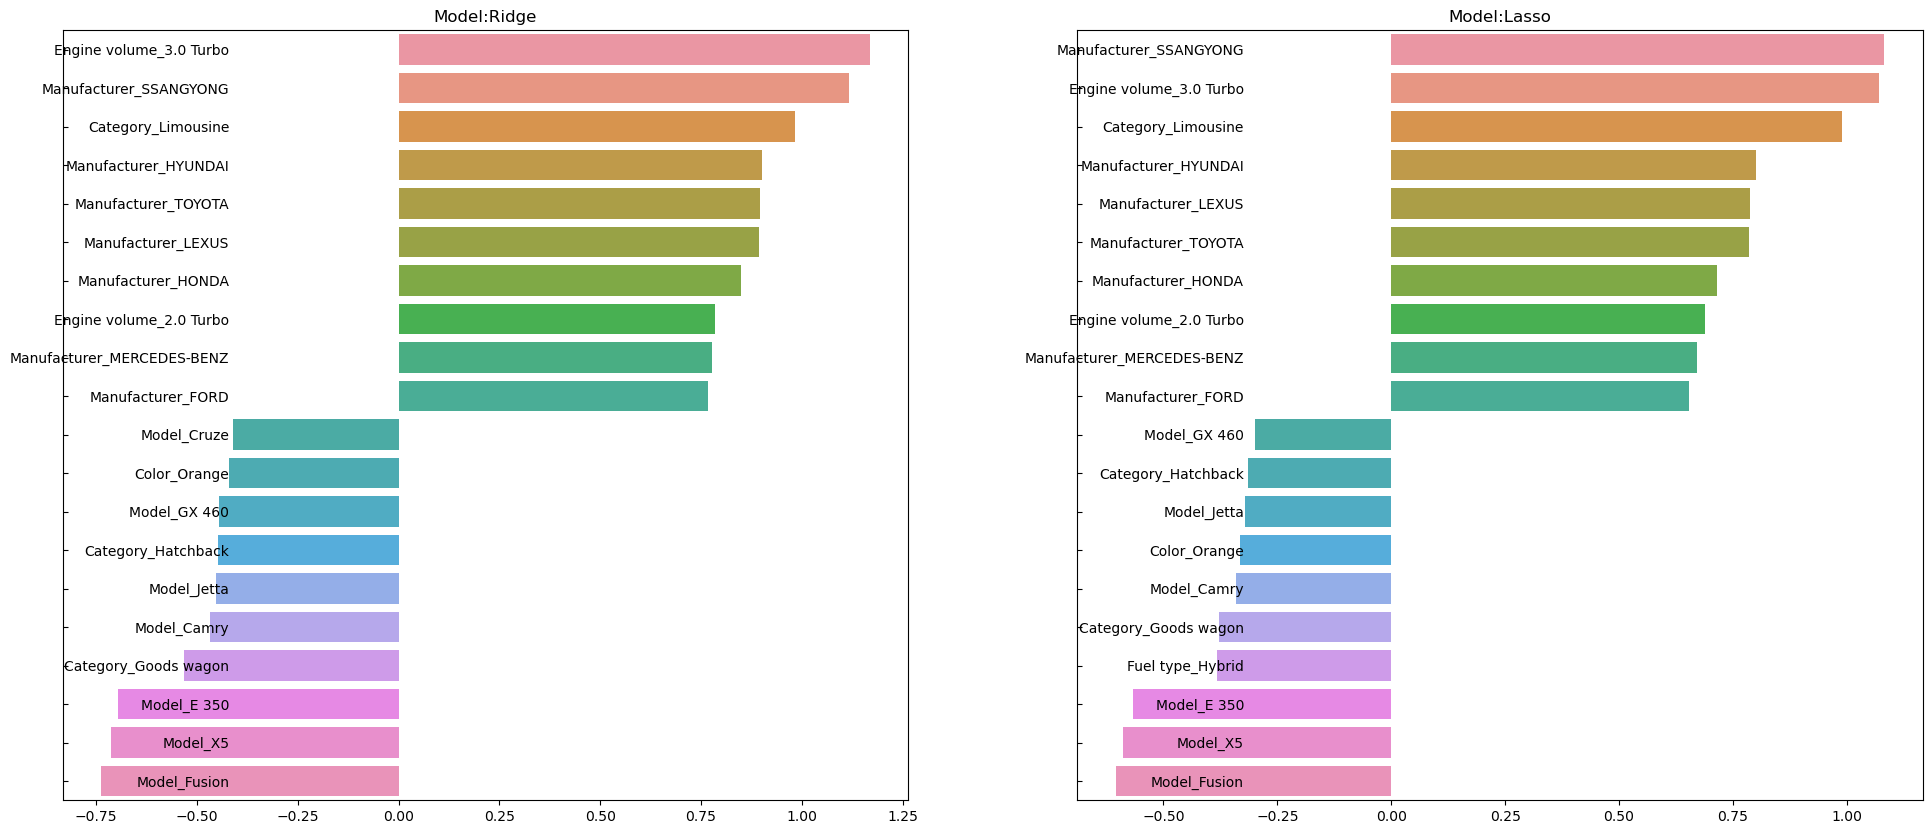

In [400]:
visualize_coef([ridge_reg_2, lasso_reg_2])

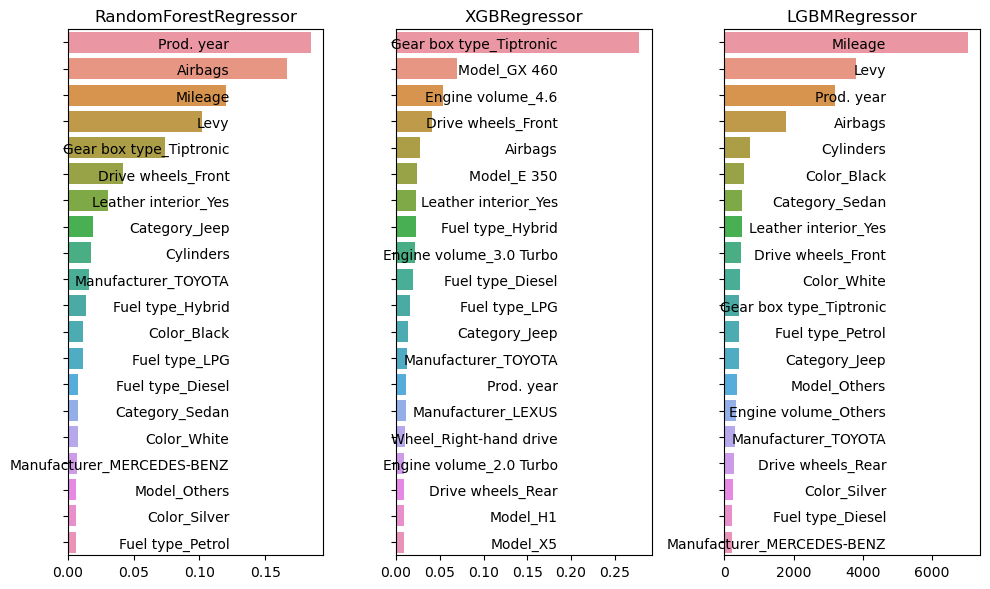

In [402]:
visualize_ftr_importances([rf_reg_2, xgb_reg_2, lgbm_reg_2])

- 시각화를 해보면 feature_importances의 분포는 크게 변화가 없다
- 다만 회귀계수의 분포는 변화가 아주 큰데, 주로 제조사와 모델의 영향력이 큰 것으로 나타났다.
- 역시나 스태킹 앙상블을 적용하고 SHAP 해석을 진행해보겠다

In [408]:
estimators = [
    ('ridge', ridge_reg_2),
    ('lasso', lasso_reg_2),
    ('random_forest', rf_reg_2),
    ('xgboost', xgb_reg_2),
    ('lgbm', lgbm_reg_2)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),  # 간단한 선형 회귀로 최종 앙상블
    cv=5,
    n_jobs=-1
)

In [411]:
stacking_model.fit(X_train, y_train)
get_rmse(stacking_model, X_test, y_test)

StackingRegressor RMSE: 0.4418


0.4418

PermutationExplainer explainer: 3383it [40:57,  1.37it/s]                                                              


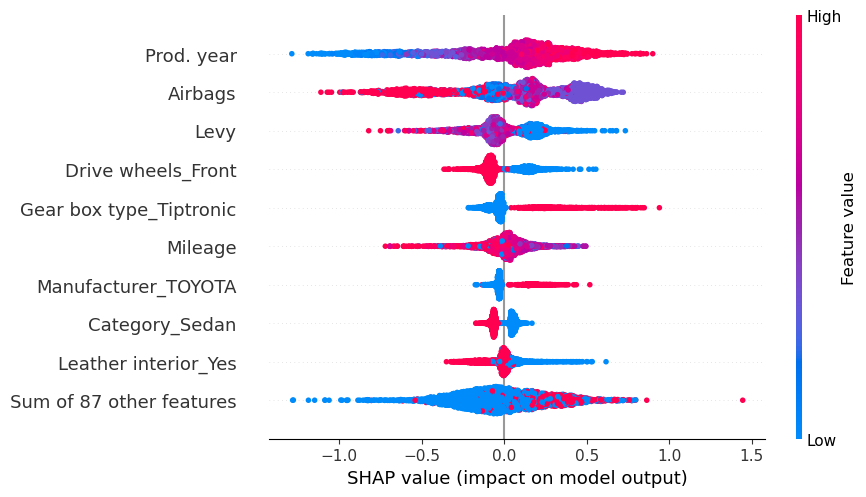

In [429]:
X_samp = X_train.sample(2000, random_state=42)
X_samp = X_samp.astype('float32')

explainer = shap.Explainer(
    stacking_model.predict, 
    X_samp,
    algorithm="permutation"
)

X_test_float = X_test.astype('float32')
shap_values = explainer(X_test_float)
shap.plots.beeswarm(shap_values)

- 이전의 결과와 거의 비슷하나 fuel_type_Diesel이 순위에서 사라졌으며 Category_Sedan이 생겼다
- 해당 결과는 샘플링을 통해 얻은 결과이기 때문에 연료 종류의 영향이 없어졌다고 판단할 수는 없으나 차량 형태 (Suv, Sedan 등)이 영향을 미친다는 사실, 특히 세단의 가격이 상대적으로 조금 더 낮다는 것을 새롭게 발견했다.
- 이 외의 피처는 앞서 얻은 결과와 같은 것으로 보아 결론은 크게 변하지 않는다.